# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [50]:
# Run some setup code for this notebook.

from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [51]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


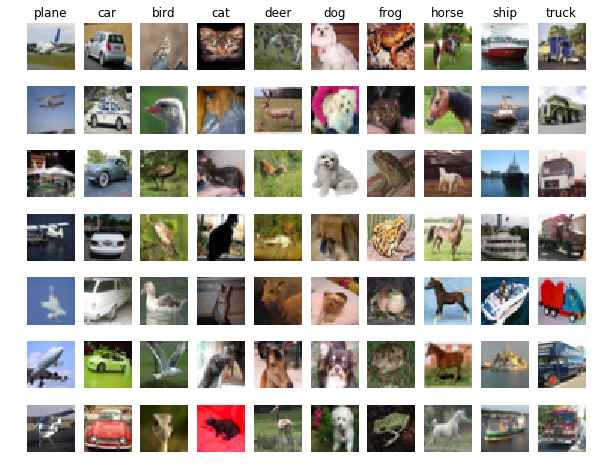

In [52]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [53]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [54]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


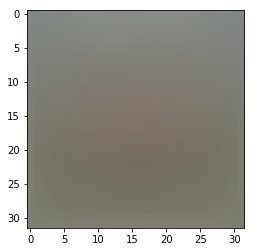

In [55]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [56]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [57]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [58]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.161021


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [59]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 7.726847 analytic: 7.726847, relative error: 4.043712e-11
numerical: 14.252959 analytic: 14.252959, relative error: 2.190323e-12
numerical: -10.620156 analytic: -10.620156, relative error: 2.963897e-13
numerical: -17.446681 analytic: -17.446681, relative error: 2.559031e-11
numerical: 19.121259 analytic: 19.121259, relative error: 8.309402e-12
numerical: -27.687568 analytic: -27.687568, relative error: 1.285094e-11
numerical: 20.440849 analytic: 20.440849, relative error: 7.481593e-12
numerical: 21.867783 analytic: 21.867783, relative error: 5.853230e-12
numerical: 10.168090 analytic: 10.168090, relative error: 2.947524e-12
numerical: -51.436937 analytic: -51.436937, relative error: 1.025037e-11
numerical: -0.262001 analytic: -0.262001, relative error: 3.199365e-10
numerical: -2.166551 analytic: -2.166551, relative error: 1.221307e-10
numerical: -6.622930 analytic: -6.622930, relative error: 4.128122e-11
numerical: 25.307220 analytic: 25.307220, relative error: 4.611314e-12


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In zero point, the SVM loss function is not differentiable.

In [60]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.161021e+00 computed in 0.080784s
Vectorized loss: 9.161021e+00 computed in 0.002995s
difference: -0.000000


In [61]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.071804s
Vectorized loss and gradient: computed in 0.001997s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [62]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1556.993476
iteration 100 / 1500: loss 210.616308
iteration 200 / 1500: loss 33.152419
iteration 300 / 1500: loss 9.279519
iteration 400 / 1500: loss 6.098480
iteration 500 / 1500: loss 5.262155
iteration 600 / 1500: loss 5.909640
iteration 700 / 1500: loss 5.517397
iteration 800 / 1500: loss 5.454165
iteration 900 / 1500: loss 5.500040
iteration 1000 / 1500: loss 5.212791
iteration 1100 / 1500: loss 5.017595
iteration 1200 / 1500: loss 5.431056
iteration 1300 / 1500: loss 5.938898
iteration 1400 / 1500: loss 5.362960
That took 6.798329s


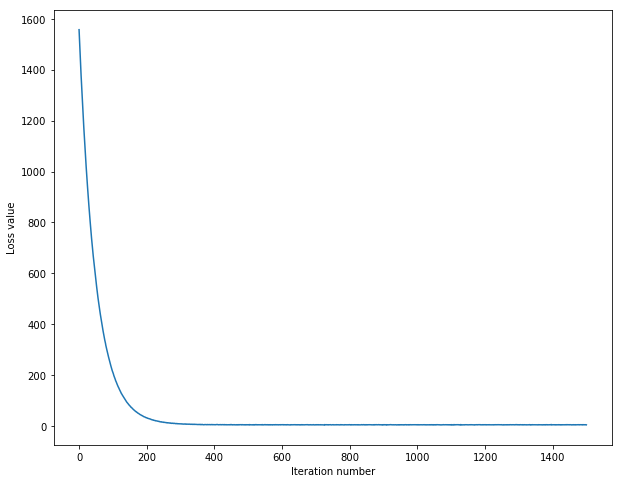

In [63]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [64]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.360449
validation accuracy: 0.372000


In [84]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
# learning_rates = [1e-7, 5e-5]
# regularization_strengths = [2.5e4, 5e4]
learning_rates = [5e-8, 5e-5]
regularization_strengths = [2.5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
import math
for i in range(100):
    print('time %d' % i)
    svm = LinearSVM()
    # lr = (learning_rates[1] - learning_rates[0]) * np.random.random() + learning_rates[0]
    lr = 10 ** ((math.log10(learning_rates[1]) - math.log10(learning_rates[0])) * np.random.random() + math.log10(learning_rates[0]))
    reg = (regularization_strengths[1] - regularization_strengths[0]) * np.random.random() + regularization_strengths[0]
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[(lr, reg)] = (training_accuracy, validation_accuracy)
    if (validation_accuracy > best_val):
        best_val = validation_accuracy
        best_svm = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

time 0
iteration 0 / 1500: loss 2941.606580
iteration 100 / 1500: loss 12.281414
iteration 200 / 1500: loss 11.994035
iteration 300 / 1500: loss 10.415505
iteration 400 / 1500: loss 10.156435
iteration 500 / 1500: loss 12.006448
iteration 600 / 1500: loss 8.980330
iteration 700 / 1500: loss 11.309613
iteration 800 / 1500: loss 11.125739
iteration 900 / 1500: loss 10.273346
iteration 1000 / 1500: loss 9.627390
iteration 1100 / 1500: loss 9.384673
iteration 1200 / 1500: loss 10.584434
iteration 1300 / 1500: loss 9.955956
iteration 1400 / 1500: loss 10.904512
time 1
iteration 0 / 1500: loss 3025.660682
iteration 100 / 1500: loss 11955716706920662919517569024.000000
iteration 200 / 1500: loss 35499125196177905114869063264870148255853015480664064.000000
iteration 300 / 1500: loss 105404629482742514794945370910670207174479930272748693959124732132199455784960.000000
iteration 400 / 1500: loss 31296928741191716330342188368622417635634568448642668132548482082949197818052471290581918173616301670

D:\code\CS231N\assignment1\cs231n\classifiers\linear_svm.py:81: RuntimeWarning: overflow encountered in double_scalars
  loss = margin.sum() / N + reg * np.sum(W * W)
D:\code\CS231N\assignment1\cs231n\classifiers\linear_svm.py:81: RuntimeWarning: overflow encountered in multiply
  loss = margin.sum() / N + reg * np.sum(W * W)


iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
time 2
iteration 0 / 1500: loss 1719.183128
iteration 100 / 1500: loss 6.519915
iteration 200 / 1500: loss 6.691840
iteration 300 / 1500: loss 6.742210
iteration 400 / 1500: loss 6.191903
iteration 500 / 1500: loss 6.441049
iteration 600 / 1500: loss 6.134105
iteration 700 / 1500: loss 6.896371
iteration 800 / 1500: loss 6.732038
iteration 900 / 1500: loss 6.269952
iteration 1000 / 1500: loss 6.472099
iteration 1100 / 1500: loss 7.472202
iteration 1200 / 1500: loss 6.880560
iteration 1300 / 1500: loss 6.815981
iteration 1400 / 1500: loss 6.305446
time 3
iteration 0 / 1500: loss 2285.594780
iteration 100 / 1500: loss 6.646048
iteration 200 / 1500: loss 5.599387
iteration 300 / 1500: loss 6.665582
iteration 400 / 1500: loss 5.660374
iteration 500 / 1500: loss 6.001918
iteration 600 / 1500: loss 6.820862
iteration 700 / 1500: loss 6.126149
iteration 800 / 1500: loss 6.246838
iteration 900 / 1500: loss 6.220138
iteration 1000 

D:\code\CS231N\assignment1\cs231n\classifiers\linear_svm.py:98: RuntimeWarning: overflow encountered in multiply
  dW += np.dot(X.T, count) / N + 2 * reg * W
D:\code\CS231N\assignment1\cs231n\classifiers\linear_svm.py:80: RuntimeWarning: invalid value encountered in less
  margin[margin < 0] = 0
D:\code\CS231N\assignment1\cs231n\classifiers\linear_svm.py:96: RuntimeWarning: invalid value encountered in greater
  count = (margin > 0).astype(int)
D:\code\CS231N\assignment1\cs231n\classifiers\linear_classifier.py:70: RuntimeWarning: invalid value encountered in subtract
  self.W -= grad * learning_rate


iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
time 9
iteration 0 / 1500: loss 2076.710762
iteration 100 / 1500: loss 4493.145127
iteration 200 / 1500: loss 4088.602744
iteration 300 / 1500: loss 4327.104753
iteration 400 / 1500: loss 4487.077441
iteration 500 / 1500: loss 4786.311498
iteration 600 / 1500: loss 4231.299410
iteration 700 / 1500: loss 4943.247442
iteration 800 / 1500: loss 4944.284944
iteration 900 / 1500: loss 4832.513447
iteration 1000 / 1500: loss 4651.151913
iteration 1100 / 1500: loss 4170.311990
iteration 1200 / 1500: loss 4229.086989
iteration 1300 / 1500: loss 4139.538254
iteration 1400 / 1500: loss 4332.448045
time 10
iteration 0 / 1500: loss 1667.395740
iteration 100 / 1500: loss 18.268756
iteratio

D:\code\CS231N\assignment1\cs231n\classifiers\linear_svm.py:78: RuntimeWarning: invalid value encountered in subtract
  margin = score - score[range(N), y].reshape(-1, 1) + 1


iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
time 13
iteration 0 / 1500: loss 2164.887741
iteration 100 / 1500: loss 83920710105555647940003116955913821376422171861403330135217713443280569965810718237194399041949047298700974914040637213187948171755520.000000
iteration 200 / 1500: loss 3152112064533704886195621615471055084856094676830702073429906691236012622038817477249618032637454455765481772826910467391245879439569993995002425141153331409320769299516362026955205122149252429307928122488872103782622176732470223242479551801587483293042972309848064.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200

iteration 300 / 1500: loss 5.733260
iteration 400 / 1500: loss 5.589775
iteration 500 / 1500: loss 6.095996
iteration 600 / 1500: loss 5.850080
iteration 700 / 1500: loss 6.006226
iteration 800 / 1500: loss 5.812485
iteration 900 / 1500: loss 5.811923
iteration 1000 / 1500: loss 6.321206
iteration 1100 / 1500: loss 5.983753
iteration 1200 / 1500: loss 6.190322
iteration 1300 / 1500: loss 6.257965
iteration 1400 / 1500: loss 5.878122
time 26
iteration 0 / 1500: loss 2740.471788
iteration 100 / 1500: loss 6.573554
iteration 200 / 1500: loss 6.139530
iteration 300 / 1500: loss 5.848254
iteration 400 / 1500: loss 6.214045
iteration 500 / 1500: loss 6.022924
iteration 600 / 1500: loss 6.104898
iteration 700 / 1500: loss 5.848913
iteration 800 / 1500: loss 6.183532
iteration 900 / 1500: loss 5.750285
iteration 1000 / 1500: loss 6.080656
iteration 1100 / 1500: loss 6.040298
iteration 1200 / 1500: loss 6.439981
iteration 1300 / 1500: loss 6.682884
iteration 1400 / 1500: loss 6.105917
time 27
i

D:\code\CS231N\assignment1\cs231n\classifiers\linear_svm.py:78: RuntimeWarning: overflow encountered in subtract
  margin = score - score[range(N), y].reshape(-1, 1) + 1


iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
time 34
iteration 0 / 1500: loss 1413.102175
iteration 100 / 1500: loss 27463407842749549023103312519205514741068997608885630249622887245818282465933049550864384.000000
iteration 200 / 1500: loss 464295277901056754936563346563144564461425670693743437603908283143327776899649992502607482503222407161256307747093144013378528086670346998250455248955108340420549967660187648.000000
iteration 300 / 1500: loss 7849357454673308989799092844615815019752209170265432382845338350373895330120949086657698986606751997508367305949712490111190471736700741738642314997341792396072631202411484998996613029946436733063592501441246834568858605200256352205974777167343114993423876096.000000
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700

iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
time 46
iteration 0 / 1500: loss 2444.660611
iteration 100 / 1500: loss 6.969683
iteration 200 / 1500: loss 6.488558
iteration 300 / 1500: loss 6.096639
iteration 400 / 1500: loss 6.170072
iteration 500 / 1500: loss 6.376486
iteration 600 / 1500: loss 6.169728
iteration 700 / 1500: loss 6.697545
iteration 800 / 1500: loss 6.100027
iteration 900 / 1500: loss 6.442971
iteration 1000 / 1500: loss 5.949456
iteration 1100 / 1500: loss 5.988800
iteration 1200 / 1500: loss 7.472533
iteration 1300 / 1500: loss 6.727674
iteration 1400 / 1500: loss 6.468093
time 47
iteration 0 / 1500: loss 1094.160916
iteration 100 / 1500: lo

iteration 1400 / 1500: loss 171.624417
time 60
iteration 0 / 1500: loss 1730.651189
iteration 100 / 1500: loss 59.083978
iteration 200 / 1500: loss 7.159212
iteration 300 / 1500: loss 5.693410
iteration 400 / 1500: loss 5.080069
iteration 500 / 1500: loss 5.554320
iteration 600 / 1500: loss 5.715699
iteration 700 / 1500: loss 5.529268
iteration 800 / 1500: loss 5.760648
iteration 900 / 1500: loss 5.609318
iteration 1000 / 1500: loss 5.646624
iteration 1100 / 1500: loss 5.848900
iteration 1200 / 1500: loss 5.499450
iteration 1300 / 1500: loss 5.580673
iteration 1400 / 1500: loss 5.591361
time 61
iteration 0 / 1500: loss 1360.121560
iteration 100 / 1500: loss 12.417502
iteration 200 / 1500: loss 5.513043
iteration 300 / 1500: loss 5.614706
iteration 400 / 1500: loss 6.043940
iteration 500 / 1500: loss 5.726104
iteration 600 / 1500: loss 5.905646
iteration 700 / 1500: loss 5.834916
iteration 800 / 1500: loss 5.479789
iteration 900 / 1500: loss 6.266942
iteration 1000 / 1500: loss 5.183881

iteration 1300 / 1500: loss 6.256074
iteration 1400 / 1500: loss 5.410232
time 74
iteration 0 / 1500: loss 2108.940368
iteration 100 / 1500: loss 6.375804
iteration 200 / 1500: loss 7.410633
iteration 300 / 1500: loss 6.654079
iteration 400 / 1500: loss 6.283752
iteration 500 / 1500: loss 5.982446
iteration 600 / 1500: loss 6.415720
iteration 700 / 1500: loss 6.098743
iteration 800 / 1500: loss 6.547462
iteration 900 / 1500: loss 6.911245
iteration 1000 / 1500: loss 7.110112
iteration 1100 / 1500: loss 6.103534
iteration 1200 / 1500: loss 6.608003
iteration 1300 / 1500: loss 6.537218
iteration 1400 / 1500: loss 6.365860
time 75
iteration 0 / 1500: loss 2062.329388
iteration 100 / 1500: loss 6.601225
iteration 200 / 1500: loss 6.979501
iteration 300 / 1500: loss 6.699323
iteration 400 / 1500: loss 7.803999
iteration 500 / 1500: loss 6.234094
iteration 600 / 1500: loss 7.005110
iteration 700 / 1500: loss 7.592176
iteration 800 / 1500: loss 7.823359
iteration 900 / 1500: loss 7.338627
ite

iteration 1200 / 1500: loss 30.180473
iteration 1300 / 1500: loss 24.727497
iteration 1400 / 1500: loss 28.067567
time 87
iteration 0 / 1500: loss 1698.665977
iteration 100 / 1500: loss 461.959712
iteration 200 / 1500: loss 129.158454
iteration 300 / 1500: loss 38.847549
iteration 400 / 1500: loss 14.846889
iteration 500 / 1500: loss 7.877114
iteration 600 / 1500: loss 6.085705
iteration 700 / 1500: loss 6.138110
iteration 800 / 1500: loss 5.635970
iteration 900 / 1500: loss 6.019696
iteration 1000 / 1500: loss 5.419647
iteration 1100 / 1500: loss 5.613566
iteration 1200 / 1500: loss 5.747811
iteration 1300 / 1500: loss 5.649704
iteration 1400 / 1500: loss 5.661215
time 88
iteration 0 / 1500: loss 2869.237171
iteration 100 / 1500: loss 105.294041
iteration 200 / 1500: loss 9.707086
iteration 300 / 1500: loss 6.541449
iteration 400 / 1500: loss 5.929669
iteration 500 / 1500: loss 6.478024
iteration 600 / 1500: loss 6.136373
iteration 700 / 1500: loss 6.100369
iteration 800 / 1500: loss 

iteration 400 / 1500: loss 6.082842
iteration 500 / 1500: loss 5.818854
iteration 600 / 1500: loss 5.922091
iteration 700 / 1500: loss 5.968514
iteration 800 / 1500: loss 5.947093
iteration 900 / 1500: loss 5.747256
iteration 1000 / 1500: loss 6.181327
iteration 1100 / 1500: loss 5.940842
iteration 1200 / 1500: loss 5.584369
iteration 1300 / 1500: loss 5.657195
iteration 1400 / 1500: loss 5.633467
lr 6.006214e-08 reg 5.392879e+04 train accuracy: 0.360776 val accuracy: 0.367000
lr 6.644287e-08 reg 5.491216e+04 train accuracy: 0.356327 val accuracy: 0.360000
lr 6.721591e-08 reg 5.260378e+04 train accuracy: 0.353980 val accuracy: 0.352000
lr 7.113909e-08 reg 3.152469e+04 train accuracy: 0.369939 val accuracy: 0.385000
lr 7.699517e-08 reg 6.760617e+04 train accuracy: 0.349939 val accuracy: 0.362000
lr 7.934180e-08 reg 9.730525e+04 train accuracy: 0.349694 val accuracy: 0.358000
lr 8.105551e-08 reg 7.679720e+04 train accuracy: 0.347551 val accuracy: 0.355000
lr 8.909115e-08 reg 9.318277e+04

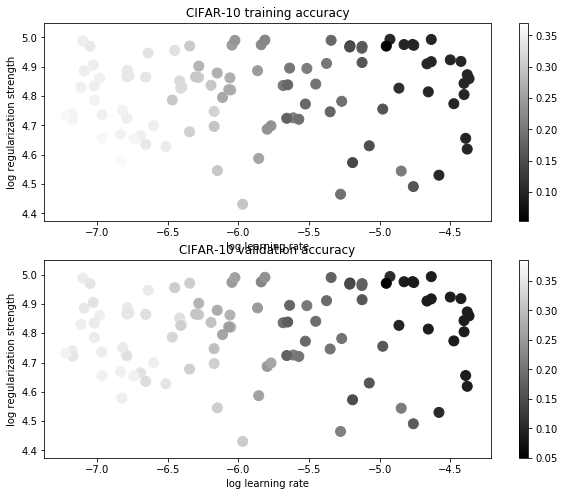

In [85]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [86]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.368000


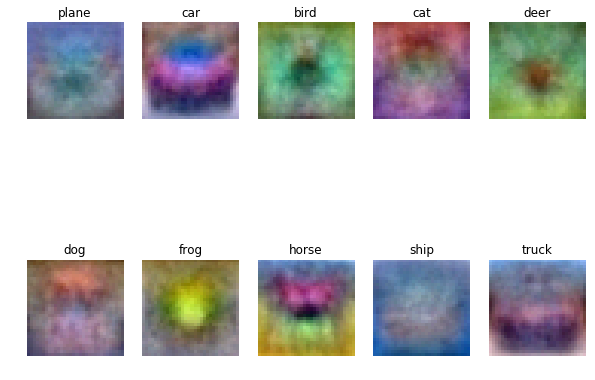

In [87]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

I don't know.